In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import sympy as sym

In [7]:
# setup of variables
m1,m2,k1,k2,k3,time = sym.symbols('m_1,m_2,k_1,k_2,k_3,t') # constants and time
x1 = sym.Function(r'\x_1')(time) # angles
x2 = sym.Function(r'\x_2')(time)
x1d = x1.diff(time) 
x2d = x2.diff(time)
x1dd = x1.diff(time,2)
x2dd = x2.diff(time,2)

# Lagrangian Setup
T = 0.5 * (k1 * x1**2 + k2 * (x1 - x2)**2 + k3 * (x2)**2)
V =  0.5 * (m1* x1d **2 + m2 * x2d**2)
L = T - V

# Get EOMs from Euler-Lagrange Equation:
left = L.diff(x1)
right = L.diff(x1d).diff(time)
x1dd = sym.solve(sym.Eq(left,right),x1dd)

left1 = L.diff(x2)
right1 = L.diff(x2d).diff(time)
x2dd = sym.solve(sym.Eq(left1,right1),x2dd)

x1dd_f = sym.lambdify([m1,m2,k1,k2,k3,x1,x2],x1dd,'numpy')
x2dd_f = sym.lambdify([m1,m2,k1,k2,k3,x1,x2],x2dd,'numpy')

def derivs(t,curr_vals,m1,m2,k1,k2,k3):

    x1,x1d,x2,x2d = curr_vals

    return x1d, x1dd_f(m1,m2,k1,k2,k3,x1,x2)[0], x2d, x2dd_f(m1,m2,k1,k2,k3,x1,x2)[0]

Initial condition in order: $x_1, \dot{x}_1,x_2, \dot{x}_2,x_3, \dot{x}_3$

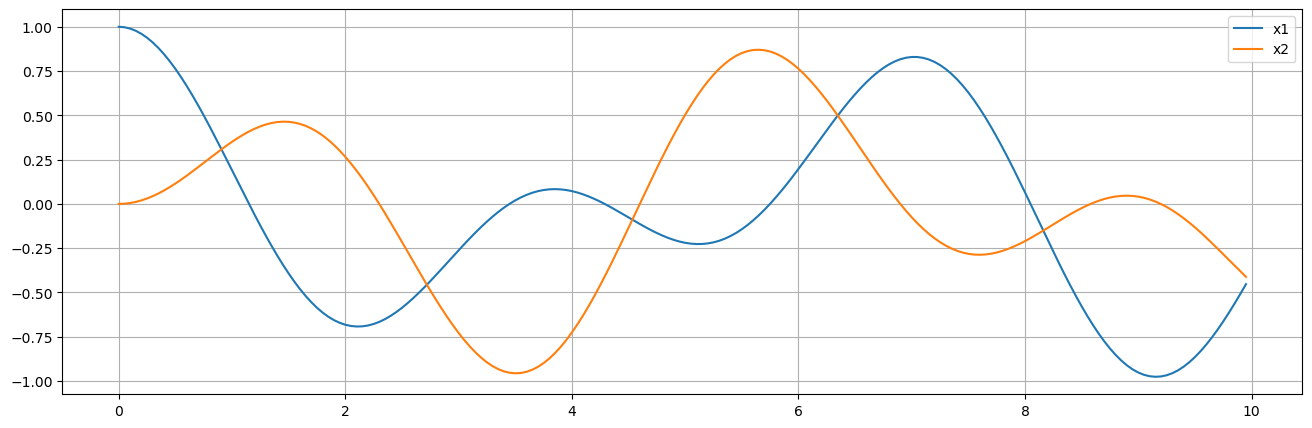

In [8]:
initial = [1,0,0,0]

tmax = 10
dt = 0.05
t = np.arange(0,tmax,dt)

m1 = 1.
m2 = 1.
m3 = 1.
k1 = 1.
k2 = 1.
k3 = 1.
k4 = 1.
#print(derivs(t,initial,m1,m2,m3,k1,k2,k3,k4))
solved = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,k1,k2,k3))

noise_sigma = 0.02
y_true = solved.y #+  noise_sigma* np.random.randn(6,len(t))
x1,x2 = y_true[0], y_true[2]

positions = np.array([solved.y[i] for i in [0,2]])

# plt.figure(figsize=(16,5))
# plt.plot(t,solved.y[0],label = 0) # x1
# plt.plot(t,solved.y[2],label = 1) #x2 #x3
# plt.plot(t,solved.y[4],label = 2)
# plt.legend()
# plt.grid()
# plt.show()

plt.figure(figsize = (16,5))
# plt.plot(t,solved.y[1],label = 3)
# plt.plot(t,solved.y[3],label = 4)
# plt.plot(t,solved.y[5],label = 5)
plt.plot(t,x1, label = 'x1')
plt.plot(t,x2, label = "x2")
plt.legend()
plt.grid()
plt.show()

In [16]:
sigma = 0.1
def log_likelihood(theta):
    k1,k2,k3 = theta
    sol = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,k1,k2,k3), method = "LSODA")
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sol.y)**2)

D = 3
LB = np.full((1, D), 0.0)  # Lower bounds
UB = np.full((1, D), 100.0)  # Upper bounds


PLB = np.full((1, D), 0.1)
PUB = np.full((1, D), 10.0)

x0 = 4.0 * np.ones((1, D))

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "display": "off",
    "max_fun_evals": 400
}

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0) # I hate this
print(LB < PLB)
print(PLB< PUB)
print(PUB < UB)

LB: [[0. 0. 0.]] PLB: [[0.1 0.1 0.1]] PUB: [[10. 10. 10.]] UB: [[100. 100. 100.]] x0: [[4. 4. 4.]]
[[ True  True  True]]
[[ True  True  True]]
[[ True  True  True]]


In [17]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior,options = options) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: 1085.600 +/-0.022.
Caution: Returned variational solution may have not converged.


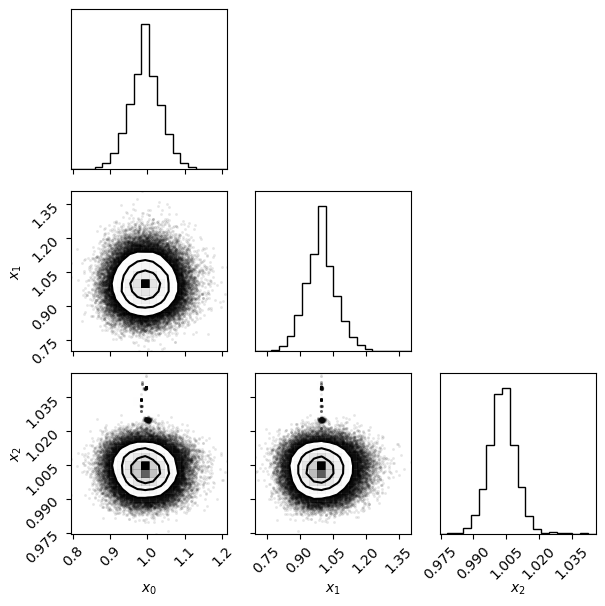

In [18]:
vp.plot();

In [19]:
vp.save("3d_for_plotting_vp.pkl")

[[0.11133748 1.47238439 0.00235398]]


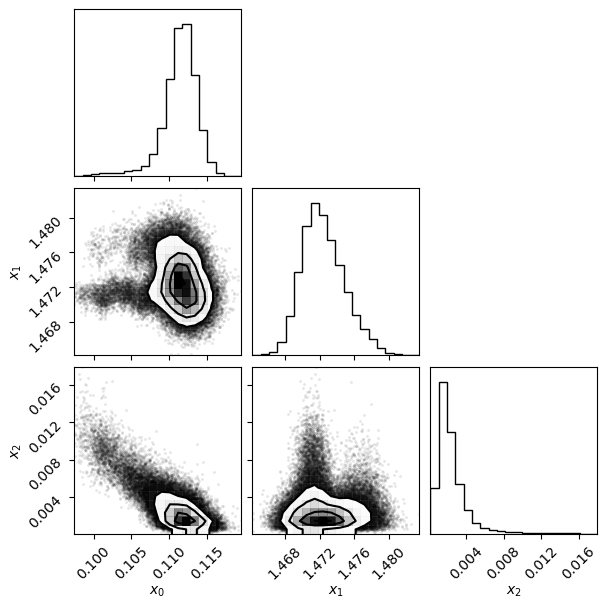

In [5]:
from pyvbmc import VariationalPosterior

wacky = VariationalPosterior.load("wild_and_wacky_3d_vp.pkl")

wacky.plot();

print(wacky.moments())

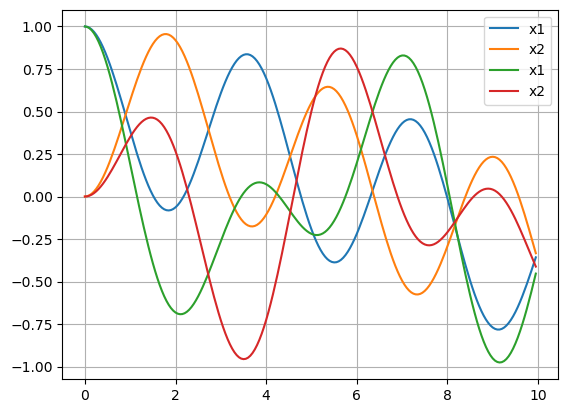

In [15]:
moments = wacky.moments()
args_list = [m1,m2,moments[0][0],moments[0][1],moments[0][2]]
sol = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = args_list, method = "LSODA")

plt.plot(t,sol.y[0], label = 'x1')
plt.plot(t,sol.y[2], label = "x2")
plt.plot(t,x1, label = 'x1')
plt.plot(t,x2, label = "x2")
plt.legend()
plt.grid()
plt.show()